In [ ]:
#default_exp warp

# Spatial versus spectral 

> Lasagna versus spaghetti  

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
%matplotlib notebook

In the previous sections we have converted and calibrated the original `.raw` spectral image data file into an analysis ready `.datastack` file. We will now gently start to learn how this three dimensional data cube is structured. Basically there are two ways to look at this data. One perspective is to think of the data cube as a stack of gray scale images. Every image has a different energy associated with it. If you remember from the previous section, these energies are the X-ray photon energies, expressed in kilo electron Volts (keV). Each image in the stack contains a distribution of intensities (photon counts). This is the lasagna view. 

Another way to think of the same data cube is to describe it as a rectangular bundle of spectra. At each spatial *(x,y)* location the data cube contains a spectrum with varying intensity along the third dimension *(z)* of the cube. This is the spaghetti view. We will come back to this in the next section.

Very roughly speaking, the spatial intensity distribution within a slice located at a specific peak energy band represents the spatial distribution of a certain chemical element. For a start we can take a look at the largest peak in the max spectrum. This peak in the energy range of 6.1-6.7 keV is caused by the presence of the chemical element iron in the drawing. Because it is the largest peak, is is called the Fe_Ka (alpha) peak. Without prior knowledge of XRF physics (we will get to this topic later on) we can compute peak slice map for this energy band.  

To do so, we need to read the required datasets with the `DataStack.read(<datapath>)` method. 

In [ ]:
from maxrf4u import DataStack 

ds = DataStack('RP-T-1898-A-3689.datastack') 

x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)

is_iron_Ka_band = (x_keVs > 6.1) * (x_keVs < 6.7) 

<IPython.core.display.Javascript object>


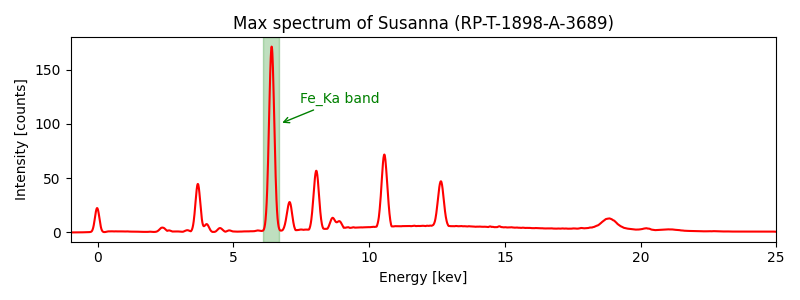

In [ ]:
#hide_input 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=[8, 3])
ax.plot(x_keVs, y_max, color='r')
ax.set_xlim([-1, 25])
ax.set_xlabel('Energy [kev]')
ax.set_ylabel('Intensity [counts]')
ax.set_title('Max spectrum of Susanna (RP-T-1898-A-3689)') 

ax.fill_between(x_keVs, 0, 1, where=is_iron_Ka_band,
                color='green', alpha=0.25, transform=ax.get_xaxis_transform(), label='Fe_Ka')
ax.annotate('Fe_Ka band', xy=(6.7, 100),  xytext=(15, 15), textcoords='offset points', color='green', 
            arrowprops=dict(arrowstyle="->", color='green'))

plt.tight_layout()

We can now compute the iron distribution image by averaging over intensity at each pixel in the 60 images in the Fe_Ka energy band and plot the image. 

In [ ]:
#hide 
np.sum(is_iron_Ka_band)

60

In [ ]:
FeKa_slice = cube[:,:,is_iron_Ka_band].compute() # load only this slice into memory 
FeKa_map = FeKa_slice.sum(axis=2) / 60 # number of channels in the Fe_Ka band 

<IPython.core.display.Javascript object>


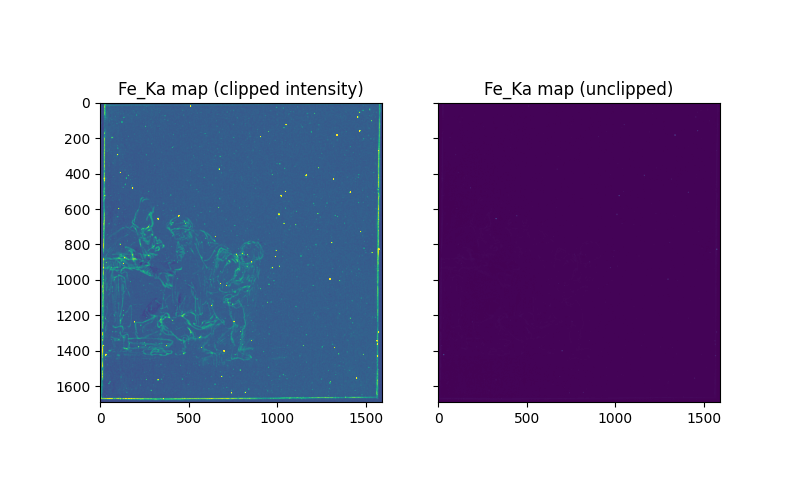

In [ ]:
import matplotlib.pyplot as plt 

fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[8, 5])

ax.imshow(FeKa_map, vmax=2);
ax.set_title('Fe_Ka map (clipped intensity)');
ax1.imshow(FeKa_map);
ax1.set_title('Fe_Ka map (unclipped)');

On the left we see here the distribution of iron associated with the iron-gall ink that Rembrandt used, as well as bright yellow speckles caused by iron particles present in the paper background. In order to make this visible, I had to clip the image intensity. On the right we see the very same image without clipping. Due to the high intensity of the iron speckles the contrast of the ink is very low.  

## Image registration helper 

Now, let's compare the iron distribution map with a photo of the drawing. In order to make such a comparison we need to register the two images. Automated registration of images is a very important capability that is unfortunately out of scope here. Instead I have created a four point warping function `warp()` that will do the job if we provide the corresponding corner points of both the source and destiny image. These corner points can be be generated using the interactive `ImageRegistrationHelper()` function as shown below. This function displays interactive map widgets with markers that need to be positioned manually to corresponding landmarks on both the source (left) and destination (right) image. in our situation it is preferred to warp the visible image onto the iron map. 

In [ ]:
from maxrf4u import ImageRegistrationHelper

In [ ]:
susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

im_src = susanna_highres
im_dst = np.clip(FeKa_map, a_min=0, a_max=2) 

In [ ]:
imreg = ImageRegistrationHelper(im_src, im_dst)

<img width=80% src="images/imreg-screenshot.png">

(Screenshot) 

In order to generate the required coordinates for the corner landmark points, you need to drag all eight markers to pairwise corresponding locations. When this is done, you can generate the actual positions that are also displayed in the text box with the `.get_corner_points_for_image_registration()` method. 

In [ ]:
imreg.get_corner_points_for_image_registration();

src_points = [[-0.5, -0.5], [4395.5, -0.5], [4395.5, 4919.5], [-0.5, 4919.5]]
dst_points = [[-0.5, -0.5], [1591.5, -0.5], [1591.5, 1691.5], [-0.5, 1691.5]]


In [ ]:
from maxrf4u import warp, append  
import numpy as np 

susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

im_src = susanna_highres
im_dst = FeKa_map 

# corner points for image registration 
pts_src = np.array([[78.5, 204.6], [4340.1, 180.4], [4374.9, 4724.9], [110.1, 4766.3]])
pts_dst = np.array([[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]])

imvis_reg_highres, extent = warp(im_src, im_dst, pts_src, pts_dst, rgba=False)
imvis_reg, extent = warp(im_src, im_dst, pts_src, pts_dst, keep_scale=False, rgba=False)

For future calculations we will store the registered images and their extent in our `.datastack` file. 

In [ ]:
#hide 

from maxrf4u import append 

append(imvis_reg, 'imvis_reg', 'RP-T-1898-A-3689.datastack')
append(imvis_reg_highres, 'imvis_reg_highres', 'RP-T-1898-A-3689.datastack')
append(extent, 'imvis_extent', 'RP-T-1898-A-3689.datastack')

ds = DataStack('RP-T-1898-A-3689.datastack')

extent = ds.read('imvis_extent')
imvis_reg_highres = ds.read('imvis_reg_highres')

<IPython.core.display.Javascript object>


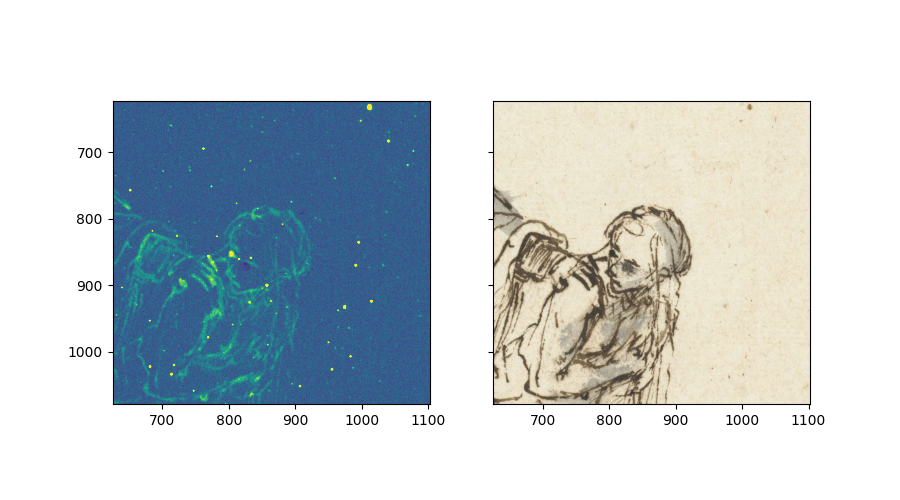

In [ ]:
#hide_input 
fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9, 5], sharex=True, sharey=True)

ax.imshow(FeKa_map, vmax=2)
ax1.imshow(imvis_reg_highres, extent=extent);

## FUNCTIONS 

In [ ]:
#export 

from IPython.display import display 
import ipyleaflet as ipl 
from ipywidgets import Text, HTML, Layout, HBox, VBox 
import ipywidgets 
from ipyleaflet import Map, ImageOverlay, basemap_to_tiles, Marker, WidgetControl
  
import io 
import matplotlib.pyplot as plt
import numpy as np
import base64 
import skimage.transform as skt 
#from skimage.io import imread
import imageio 

import skimage 

import numpy as np
import cv2 


def img_to_url(img_data, max_width=None): 
    '''Filename or numpy array *img_data* is transformed into 256 bit color compressed base64 encoded url string. 
    
    To reduce image size specify thumbnail `max_width`. 
    
    Returns: url_string, shape'''
        
    try: 
        # better than matplotlib use skimage.io.imread to avoid float explosion...
        img = imageio.imread(img_data) # if img_data is an image file path 
    except: 
        img = img_data # otherwise assume img_data is an image like numpy array  
        
    shape = img.shape[0:2] # height and width only 
    h, w = shape 
    
    # rescaling image if width > max_width 
    if max_width is not None:  
        if w > max_width:
            scale = max_width / w  
            img = skt.rescale(img, scale, multichannel=True) 
            
    # reduce colors to 256 levels to keep file size minimal 
    img_ubyte = skimage.util.img_as_ubyte(img)
    
    # write to buffer 
    buff = io.BytesIO();
    plt.imsave(buff, img_ubyte, format='png')
   
    
    # convert to base64 string 
    base64_string = base64.b64encode(buff.getvalue()).decode("ascii")
    url_string = f'data:image/png;base64,{base64_string}' 
    
    # let's close buffer just in case
    buff.close()
    
 
    return url_string, shape 


def mark_corners(map_, img_shape): 

    h, w = img_shape[0:2] 

    corners = [[h, 0], [h, w], [0, w], [0, 0]] 
    colors = ['red', 'green', 'blue', 'orange']
    labels = ['top left', 'top right', 'bottom right', 'bottom left']

    markers = [] 

    for location, color, label in zip(corners, colors, labels): 
        icon = ipl.AwesomeIcon(name='circle-o', marker_color=color)
        marker = Marker(location=location, draggable=True, title=f'Drag me to {label} landmark', icon=icon)
        markers.append(marker)
        map_.add(marker) 
    
    return markers 


# callback 
def on_marker_move(change): 
    
    textbox.value = extract_corner_points(src_markers, src_shape, dst_markers, dst_shape, return_text=True)

    
    
def extract_corner_points(src_markers, src_shape, dst_markers, dst_shape, return_text=False): 
    '''Flip coordinates to make top of image zero. 
    
    Returns: pts_string 
    '''
    
    src_pts = []
    h, w = src_shape 
    for marker in src_markers:   
        y, x = marker.location 
        xy_flip = [ x - 0.5, h - y - 0.5]
        src_pts.append(xy_flip)
             
    dst_pts = []
    h, w = dst_shape  
    for marker in dst_markers:   
        y, x = marker.location 
        xy_flip = [ x - 0.5, h - y - 0.5]
        dst_pts.append(xy_flip)
        
    if return_text:     
        # two decimal strings for textbox 
        src_pts_string = 'src_pts = ' + ', '.join([f'[{y:.02f}, {x:.02f}]' for [y, x] in src_pts])
        dst_pts_string = 'dst_pts = ' + ', '.join([f'[{y:.02f}, {x:.02f}]' for [y, x] in dst_pts])

        pts_string = f'# corner points for image registration: \n{src_pts_string}\n{dst_pts_string}'

        return pts_string 
    
    else: 
        return src_pts, dst_pts 

    
    
class ImageRegistrationHelper(object): 
    
    def on_marker_move_(self, change): 
            
            self.textbox.value = extract_corner_points(self.src_markers, self.src_shape, 
                                                       self.dst_markers, self.dst_shape, 
                                                       return_text=True) 
            
    def get_corner_points_for_image_registration(self, verbose=True): 
        '''Get 4 source and 4 destination corner points for image registration. 
        
        Extracts current positions from all markers. Output can be used in warp function. 
        
        Returns: src_points, dst_points
        '''
        
        src_points, dst_points = extract_corner_points(self.src_markers, self.src_shape, 
                                           self.dst_markers, self.dst_shape, 
                                           return_text=False)
        
        print(f'src_points = {src_points}\ndst_points = {dst_points}')
        
        src_points = np.array(src_points) 
        dst_points = np.array(dst_points)
        
        return src_points, dst_points 
        
    
    def __init__(self, src_imdata, dst_imdata): 
        
        layout = Layout(width='500px', height='500px')
        resolutions = [256 * 2 ** (-l) for l in range(20)]
 
        crs = dict(name='Pixelcoords', custom=True, bounds=[[0, 0], [1000, 1000]], origin=[0, 0], 
                    resolutions=resolutions, proj4def='+proj=longlat')
    

        # read images and convert to png/base64 url  
        src_url, self.src_shape = img_to_url(src_imdata) 
        dst_url, self.dst_shape = img_to_url(dst_imdata) 
        
        
        src_h, src_w = self.src_shape 
        self.src_map = Map(scroll_wheel_zoom=True, crs=crs, center=[src_h/2, src_w/2], zoom=4, 
                      layout=layout, interpolation='nearest')

        dst_h, dst_w = self.dst_shape
        self.dst_map = Map(scroll_wheel_zoom=True, crs=crs, center=[dst_h/2, dst_w/2], zoom=4, 
                      layout=layout, interpolation='nearest')
        
        self.src_markers = mark_corners(self.src_map, self.src_shape)
        self.dst_markers = mark_corners(self.dst_map, self.dst_shape)

        src_imo = ImageOverlay(url=src_url, bounds=[[0, 0], self.src_shape]) # SW and NE corners
        dst_imo = ImageOverlay(url=dst_url, bounds=[[0, 0], self.dst_shape]) # SW and NE corners

        self.src_map.add(src_imo)
        self.dst_map.add(dst_imo)

        # this hack removes the default world map layer 
        # (seems I can do that only after creating other widgets) 
        self.src_map.remove(self.src_map.layers[0]) 
        self.dst_map.remove(self.dst_map.layers[0])

        for marker in self.src_markers: 
            marker.observe(self.on_marker_move_)

        for marker in self.dst_markers: 
            marker.observe(self.on_marker_move_)

        # initialize textbox    
        self.pts_string = extract_corner_points(self.src_markers, self.src_shape, 
                                           self.dst_markers, self.dst_shape, 
                                           return_text=True)

        self.textbox = ipywidgets.Textarea(self.pts_string, rows=3, layout=Layout(width='100%'))

        self.combi = VBox([HBox([self.src_map, self.dst_map]), self.textbox])
        
        display(self.combi)


        
def warp(im_src, im_dst, pts_src, pts_dst, keep_scale=True, rgba=True, alpha_color=[1, 0, 0]): 
    '''Opencv based homographic registration. Can return transparent overlay (rgba). 
    
    Returns: *im_warped*, *extent* '''

    src_h, src_w = im_src.shape[0:2]
    dst_h, dst_w = im_dst.shape[0:2]
    
    if keep_scale: 
        scale = src_h / dst_h 
    else: 
        scale = 1

    # calculate homography 
    hom, status = cv2.findHomography(pts_src, scale * pts_dst)

    # Size is nearest integer scaled (width,height) of im_dst
    size = round(scale * dst_w), round(scale * dst_h)
    
    # warp im_src onto destination 
    im_warped = cv2.warpPerspective(im_src, hom, size) 
    
    # warp white onto destination to create mask 
    mask_src = np.ones([src_h, src_w])
    mask_warped = cv2.warpPerspective(mask_src, hom, size) 
    
    # calculate extent for plotting 
    h, w = im_dst.shape[0:2] 
    extent =  (0, w, h, 0) 
    
    # convert into rgba image  
    if rgba is True: 
        im_rgba = np.ones([h, w, 4])

        # for single channel image 
        if len(im_src.shape) == 2:
            # colorize
            im_rgba[:,:,0:3] = alpha_color[0:3] 
            #  make alpha layer 
            im_rgba[:,:,3] = im_warped 
            
        # otherwise assume image is rgb
        elif len(im_warped.shape) == 3: 
            
            # rgb channels
            im_rgba[:,:,0:3] = im_warped[:,:,0:3]
            # alpha channels 
            im_rgba[:,:,3] = mask_warped
       
        im_warped = im_rgba 
    
    return im_warped, extent  

